# Make bathymetry with Kaitlin's functions

In [ ]:
import numpy as np
import xarray as xr
import sys  
sys.path.insert(0, '/home/users/birgal/')
from nemo_python import make_domain as md
from nemo_python import plots
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cmocean

from shapely import geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [ ]:
import pyproj
from shapely.ops import transform

#### Functions

In [2]:
def prepare_plot(figsize=(15, 15), dpi=300):
    """This function returns prepared axes for the polar plot.
    
    Usage:
        fig, ax = prepare_plot()
    """
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.set_boundary(map_circle, transform=ax.transAxes)
    # ax.coastlines(); 
    gl = ax.gridlines(draw_labels=True, ylocs=[]);#, color='w', lw=2);
    return fig, ax

In [3]:
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

#### Visualize grid

In [28]:
gridT     = xr.open_dataset('/home/users/birgal/data/NEMO-test3-20230914/eANT025.L121_1m_19790101_19791231_grid_T.nc')

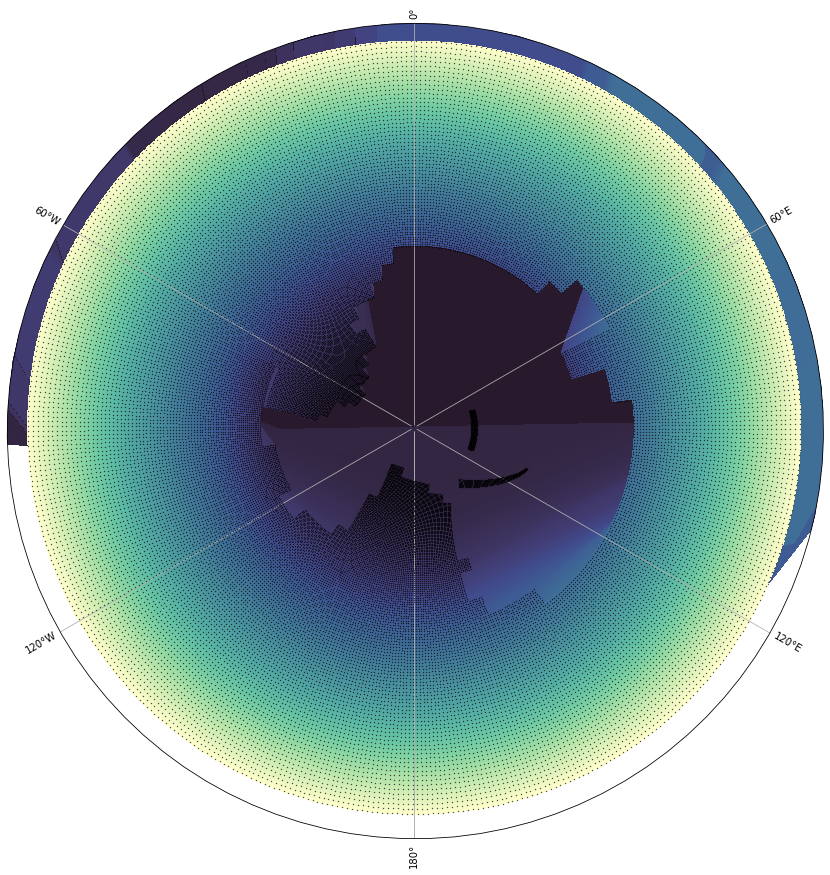

In [57]:
fig, ax = prepare_plot()
cm1 = ax.pcolormesh(gridT['nav_lon_grid_T'], gridT['nav_lat_grid_T'], gridT['area_grid_T'], 
                    transform=ccrs.PlateCarree(), cmap=cmocean.cm.deep_r);
cont1 = ax.scatter(gridT['nav_lon_grid_T'][::3,::3], 
                   gridT['nav_lat_grid_T'][::3,::3], 
                   zorder=3, transform=ccrs.PlateCarree(), s=0.1, c='k')

# CB = fig.colorbar(cm1, ax=ax, fraction=0.04)
# CB.add_lines(cont1)

### Steps 1-2

Kaitlin has done steps 1-2, with the below output files:

In [4]:
bed   = xr.open_dataset('/gws/nopw/j04/terrafirma/kaight/input_data/topo/BedMachineAntarctica-v3.nc')
coord = xr.open_dataset('./coordinates_AIS.nc').squeeze()
BedMachine = xr.open_dataset('./eORCA025_BedMachine3_AIS.nc')
IBCSO = xr.open_dataset('/home/users/birgal/data/input_data/topo/IBCSO_v2_bed_WGS84.nc')

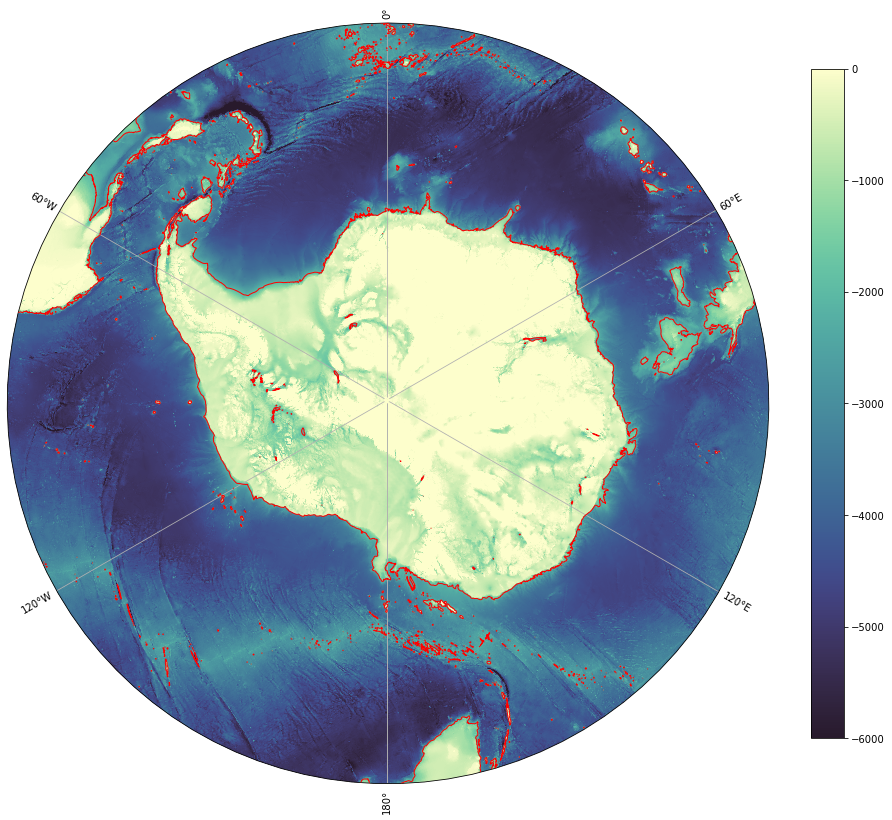

In [5]:
fig, ax = prepare_plot()
cm1 = ax.pcolormesh(IBCSO['lon'][::10], 
                    IBCSO['lat'][::5],
                    IBCSO['z'][::5,::10], 
                    transform=ccrs.PlateCarree(), vmin=-6000, vmax=0, cmap=cmocean.cm.deep_r);

x, y = np.meshgrid(IBCSO['lon'], IBCSO['lat'])
cs = ax.contour(x, y, IBCSO['z'], levels=[-2000], colors='r', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())

CB = fig.colorbar(cm1, ax=ax, fraction=0.04)
# CB.add_lines(cont1)

In [6]:
# Create largest polygon based on 2000 m contour line (excluding holes)
for ncp, cp in enumerate(cs.collections[0].get_paths()[0].to_polygons()):
    isobath_2000m = geometry.Polygon([(i[0], i[1]) for i in zip(cp[:,0],cp[:,1])])

In [8]:
x_iso, y_iso = isobath_2000m.exterior.xy
x_iso1 = np.ma.masked_where(np.array(x_iso) < 0, np.array(x_iso))
y_iso1 = np.ma.masked_where(np.array(x_iso) < 0, np.array(y_iso))
x_iso2 = np.ma.masked_where(np.array(x_iso) >= 0, np.array(x_iso))
y_iso2 = np.ma.masked_where(np.array(x_iso) >= 0, np.array(y_iso))

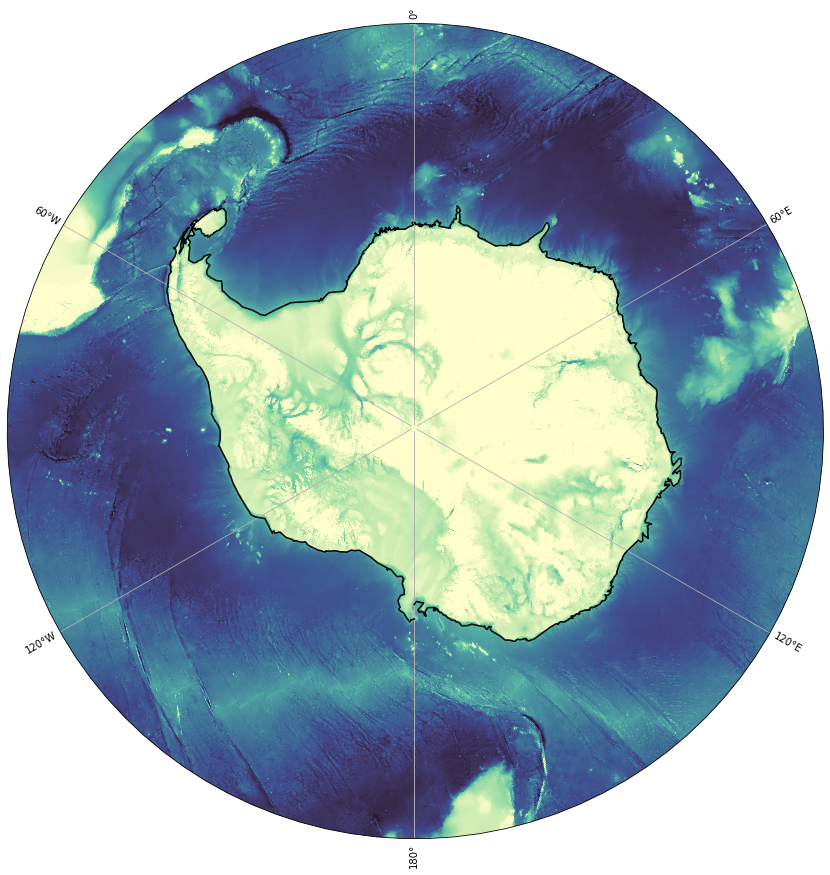

In [8]:
fig, ax = prepare_plot()
cm1 = ax.pcolormesh(IBCSO['lon'][::10], 
                    IBCSO['lat'][::5],
                    IBCSO['z'][::5,::10], 
                    transform=ccrs.PlateCarree(), vmin=-6000, vmax=0, cmap=cmocean.cm.deep_r);

ax.plot(x_iso1, y_iso1, c='k', zorder=4, transform=ccrs.PlateCarree())
ax.plot(x_iso2, y_iso2, c='k', zorder=4, transform=ccrs.PlateCarree())

# CB = fig.colorbar(cm1, ax=ax, fraction=0.04)
# CB.add_lines(cont1)

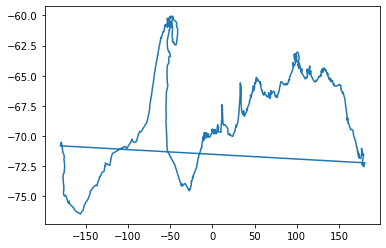

In [9]:
plt.plot(x_iso, y_iso)

In [11]:
wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:32618')

project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
utm_isobath = transform(project, isobath_2000m)

project_back  = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform
polar_isobath = transform(project, utm_isobath)

In [45]:
utm_isobath.contains(transform(project, Point(100, -73)))

True

In [22]:
x_IBCSO, y_IBCSO = np.meshgrid(IBCSO['lon'], IBCSO['lat'])

In [23]:
# Mask array outside of polygon area
lons_outside_2000m = np.ma.masked_where(, x_IBCSO)

(3757, 33812)

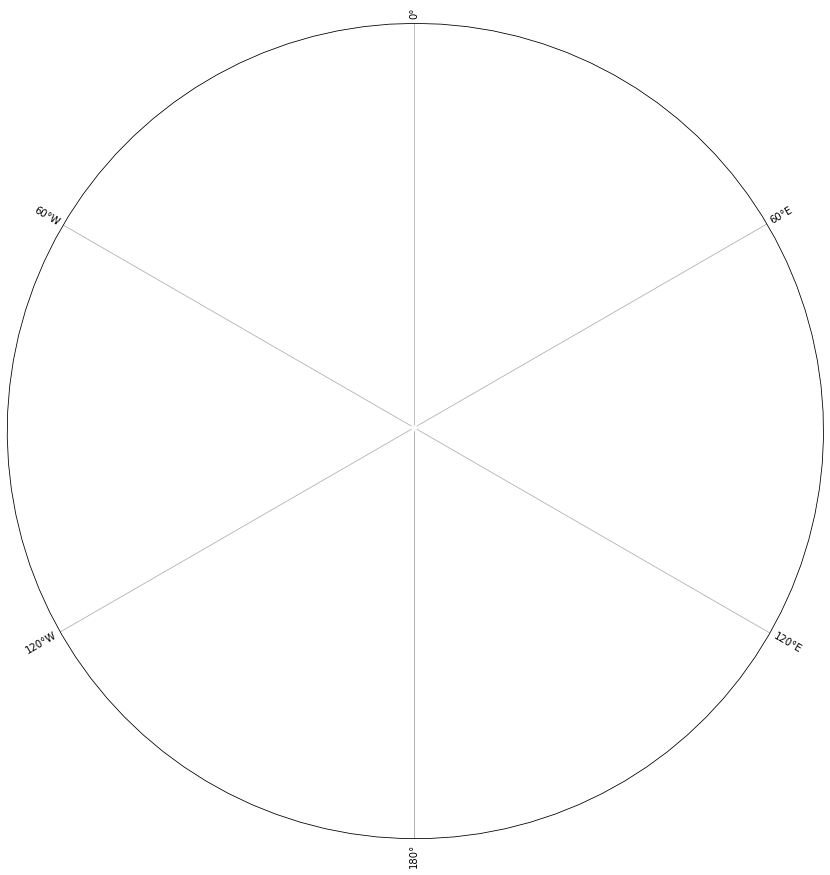

In [51]:
fig, ax = prepare_plot()
# cm1 = ax.pcolormesh(IBCSO['lon'][::10], 
#                     IBCSO['lat'][::5],
#                     IBCSO['z'][::5,::10], 
#                     transform=ccrs.PlateCarree(), vmin=-6000, vmax=0, cmap=cmocean.cm.deep_r);

x_utm, y_utm = utm_isobath.exterior.xy
ax.plot(x_utm, y_utm, c='k', zorder=4, transform=ccrs.PlateCarree())

# CB = fig.colorbar(cm1, ax=ax, fraction=0.04)
# CB.add_lines(cont1)

Visualize bathymetry in this step:

In [5]:
x1 = np.ma.masked_where(coord['nav_lon'][0:453,:] < 0, coord['nav_lon'][0:453,:])
y1 = np.ma.masked_where(coord['nav_lon'][0:453,:] < 0, coord['nav_lat'][0:453,:])
z1 = np.ma.masked_where(coord['nav_lon'][0:453,:] < 0, BedMachine['bathy'][0:453,:])

x2 = np.ma.masked_where(coord['nav_lon'][0:453,:] >= 0, coord['nav_lon'][0:453,:])
y2 = np.ma.masked_where(coord['nav_lon'][0:453,:] >= 0, coord['nav_lat'][0:453,:])
z2 = np.ma.masked_where(coord['nav_lon'][0:453,:] >= 0, BedMachine['bathy'][0:453,:])

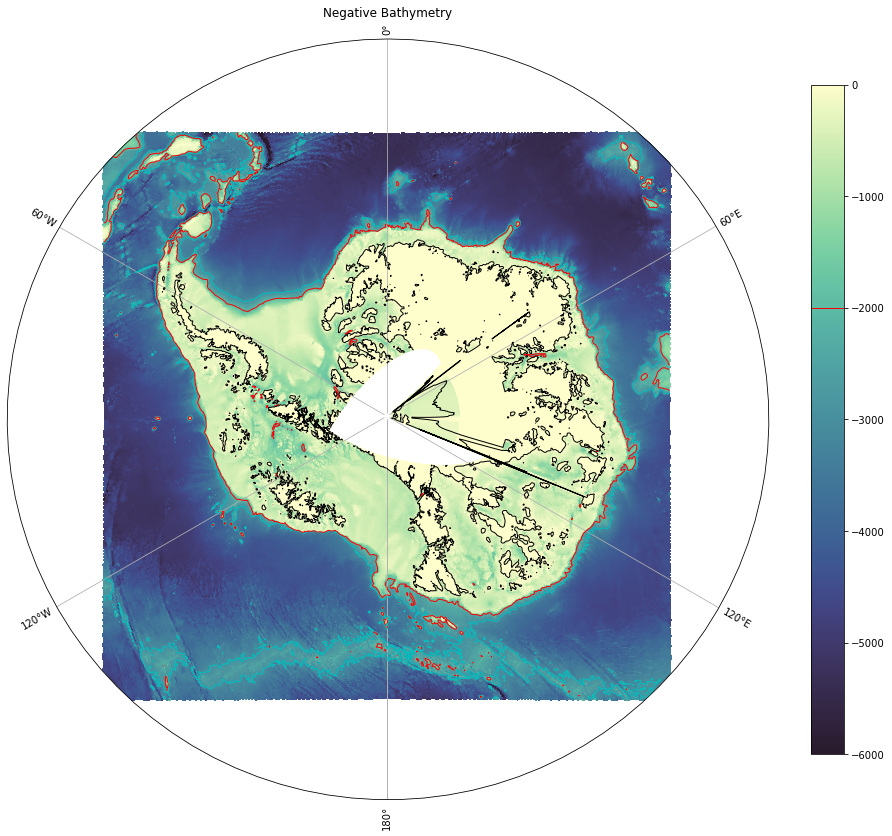

In [60]:
fig, ax = prepare_plot()
cm1 = ax.pcolormesh(coord['nav_lon'][0:453,:], 
                    coord['nav_lat'][0:453,:], 
                    BedMachine['bathy'], 
                    transform=ccrs.PlateCarree(), vmin=-6000, vmax=0, cmap=cmocean.cm.deep_r);

ax.set_title('Negative Bathymetry');
cont1 = ax.contour(x1, y1, z1, levels=[-3000], colors='c', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
cont2 = ax.contour(x2, y2, z2, levels=[-3000], colors='c', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
cont1 = ax.contour(x1, y1, z1, levels=[-2000], colors='r', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
cont2 = ax.contour(x2, y2, z2, levels=[-2000], colors='r', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
cont3 = ax.contour(x1, y1, z1, levels=[0], colors='k', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
cont4 = ax.contour(x2, y2, z2, levels=[0], colors='k', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())

CB = fig.colorbar(cm1, ax=ax, fraction=0.04)
CB.add_lines(cont1)

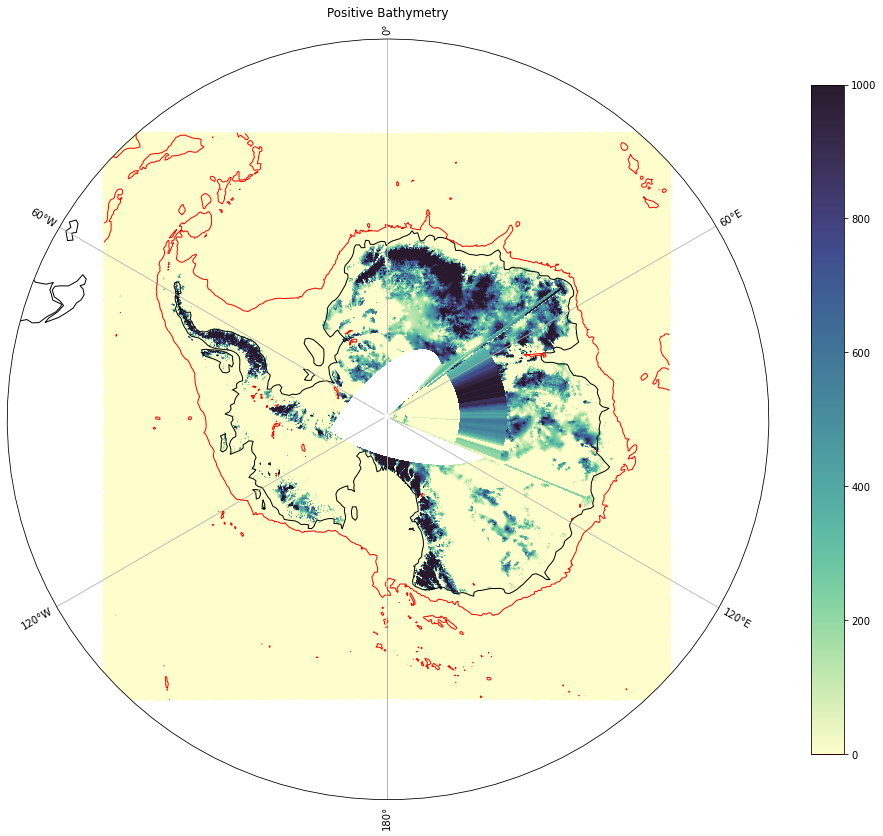

In [91]:
fig, ax = prepare_plot()
cm1 = ax.pcolormesh(coord['nav_lon'][0:453,:], 
                    coord['nav_lat'][0:453,:], 
                    BedMachine['bathy'], 
                    transform=ccrs.PlateCarree(), vmin=0, vmax=1000, cmap=cmocean.cm.deep);

ax.set_title('Positive Bathymetry');
cont1 = ax.contour(x1, y1, z1, levels=[-2000], colors='r', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
cont2 = ax.contour(x2, y2, z2, levels=[-2000], colors='r', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())

CB = fig.colorbar(cm1, ax=ax, fraction=0.04)
CB.add_lines(cont1)

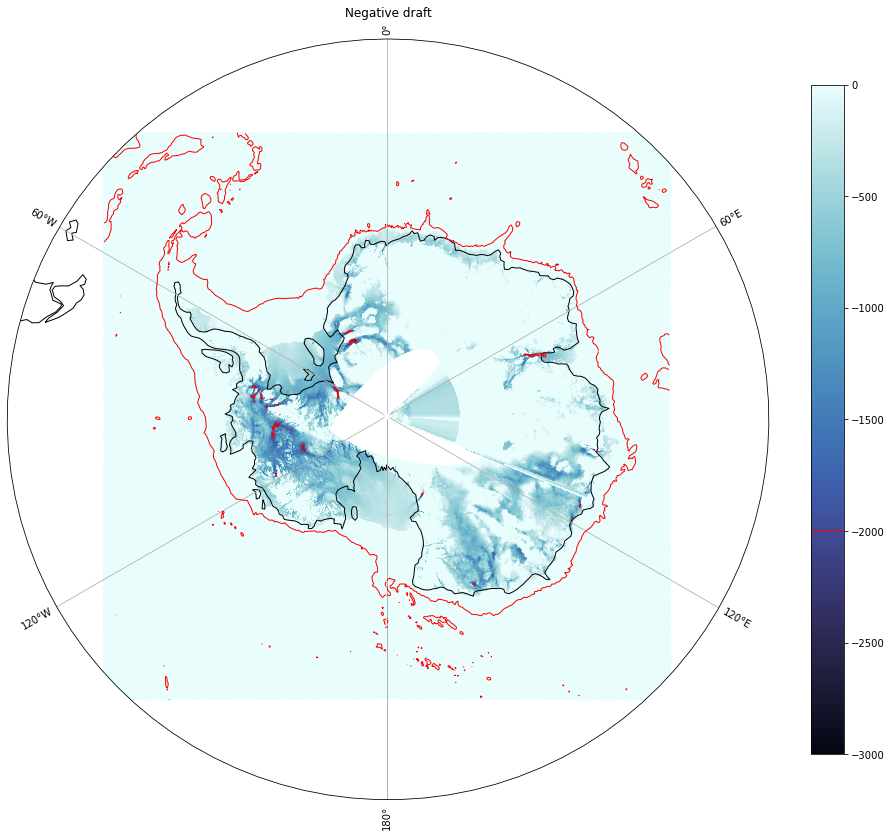

In [87]:
fig, ax = prepare_plot()
cm1 = ax.pcolormesh(coord['nav_lon'][0:453,:], 
                    coord['nav_lat'][0:453,:], 
                    BedMachine['draft'], 
                    transform=ccrs.PlateCarree(), vmin=-3000, vmax=0, cmap=cmocean.cm.ice);

ax.set_title('Negative draft');
cont1 = ax.contour(x1, y1, z1, levels=[-2000], colors='r', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
cont2 = ax.contour(x2, y2, z2, levels=[-2000], colors='r', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())

CB = fig.colorbar(cm1, ax=ax, fraction=0.04)
CB.add_lines(cont1)

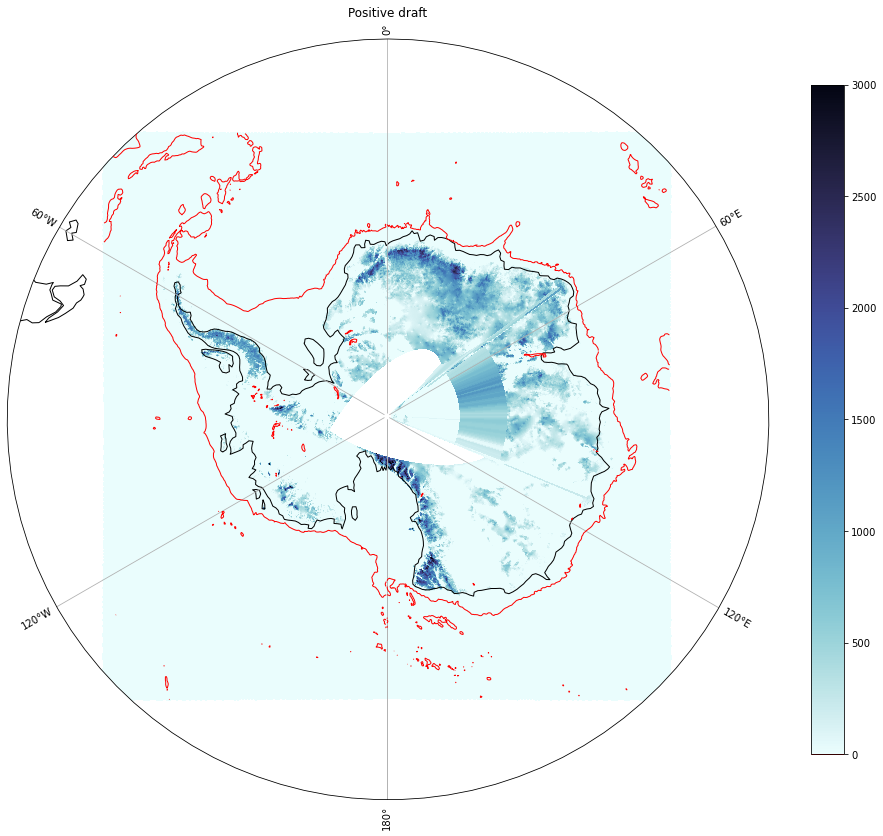

In [86]:
fig, ax = prepare_plot()
cm1 = ax.pcolormesh(coord['nav_lon'][0:453,:], 
                    coord['nav_lat'][0:453,:], 
                    BedMachine['draft'], 
                    transform=ccrs.PlateCarree(), vmin=0, vmax=3000, cmap=cmocean.cm.ice_r);

ax.set_title('Positive draft');
cont1 = ax.contour(x1, y1, z1, levels=[-2000], colors='r', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())
cont2 = ax.contour(x2, y2, z2, levels=[-2000], colors='r', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())

CB = fig.colorbar(cm1, ax=ax, fraction=0.04)
CB.add_lines(cont1)

### Step 3

In [ ]:
md.fill_missing_topo()

Processing input data


In [ ]:
md.process_topo()

In [ ]:
md.splice_topo()